In [1]:
! git clone https://github.com/stefyste/RIAWELC.git

Cloning into 'RIAWELC'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 528 (delta 4), reused 103 (delta 0), pack-reused 382
Receiving objects: 100% (528/528), 471.32 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (20/20), done.


In [ ]:
!pip install pyunpack
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
from pyunpack import Archive

rar_file = '/content/RIAWELC/Dataset_partitioned/RIAWELC_dataset.part01.rar'
output_dir = '/content/extracted_data'
os.mkdir(output_dir)
Archive(rar_file).extractall(output_dir)

In [ ]:
train_dir = '/content/extracted_data/DB - Copy/training'
validation_dir = '/content/extracted_data/DB - Copy/validation'
test_dir = '/content/extracted_data/DB - Copy/testing'

**Helper Functions**

---



In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os



# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    return class_names[target_image_pred_label.cpu()],target_image_pred_probs.max().cpu()

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs

    checkpoint_path = '/content/drive/MyDrive/Stage/Stage Falcon/model_checkpoint.pth'

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        torch.save(checkpoint, checkpoint_path)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
# from helper_functions import set_seeds

In [ ]:
def model():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  device
  # 1. Get pretrained weights for ViT-Base
  pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2. Setup a ViT model instance with pretrained weights
  pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

  # 3. Freeze the base parameters
  for parameter in pretrained_vit.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head
  class_names = [conda]

  set_seeds()
  pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
  # pretrained_vit # uncomment for model output

  return(pretrained_vit)


'cuda'

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    validation_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  validation_data = datasets.ImageFolder(validation_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      validation_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     validation_dir=validation_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could

NameError: ignored

**Training**


---



In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2498 | train_acc: 0.9169 | test_loss: 0.1526 | test_acc: 0.9510
Epoch: 2 | train_loss: 0.1388 | train_acc: 0.9540 | test_loss: 0.1212 | test_acc: 0.9569
Epoch: 3 | train_loss: 0.1144 | train_acc: 0.9620 | test_loss: 0.1064 | test_acc: 0.9650
Epoch: 4 | train_loss: 0.1017 | train_acc: 0.9669 | test_loss: 0.0951 | test_acc: 0.9685
Epoch: 5 | train_loss: 0.0916 | train_acc: 0.9714 | test_loss: 0.0898 | test_acc: 0.9678
Epoch: 6 | train_loss: 0.0839 | train_acc: 0.9740 | test_loss: 0.0830 | test_acc: 0.9727
Epoch: 7 | train_loss: 0.0786 | train_acc: 0.9752 | test_loss: 0.0774 | test_acc: 0.9733
Epoch: 8 | train_loss: 0.0742 | train_acc: 0.9762 | test_loss: 0.0741 | test_acc: 0.9755
Epoch: 9 | train_loss: 0.0691 | train_acc: 0.9778 | test_loss: 0.0731 | test_acc: 0.9757
Epoch: 10 | train_loss: 0.0665 | train_acc: 0.9794 | test_loss: 0.0693 | test_acc: 0.9766
Epoch: 11 | train_loss: 0.0632 | train_acc: 0.9802 | test_loss: 0.0715 | test_acc: 0.9770
Epoch: 12 | train_l

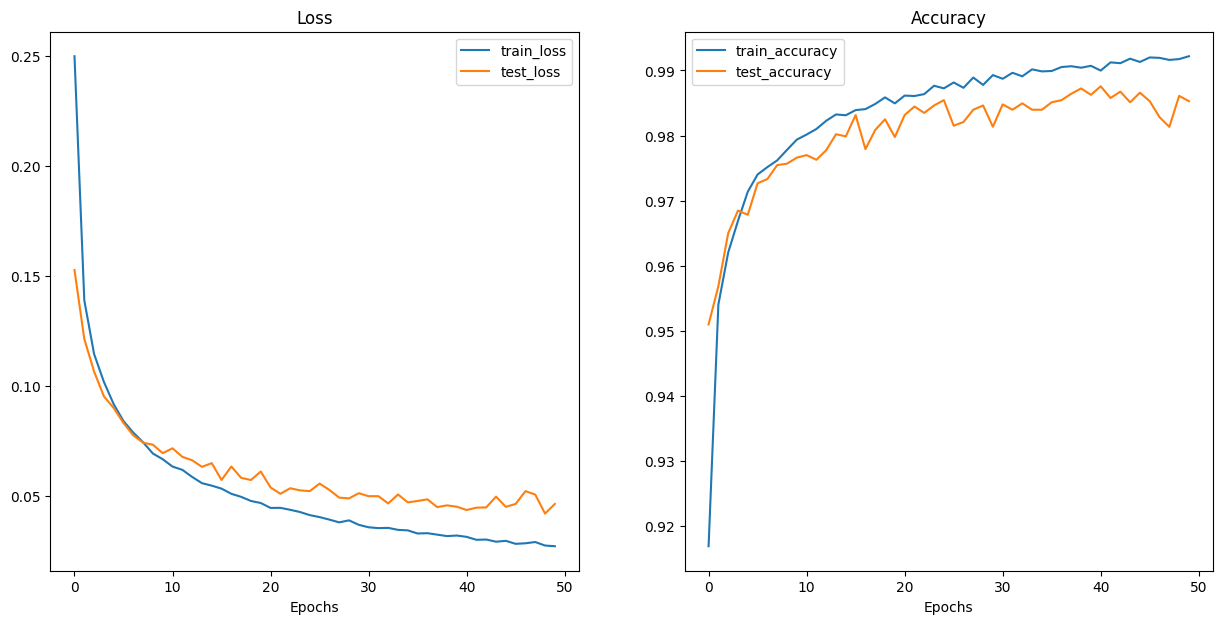

In [ ]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

**Inference**


---



In [ ]:
import requests
import cv2

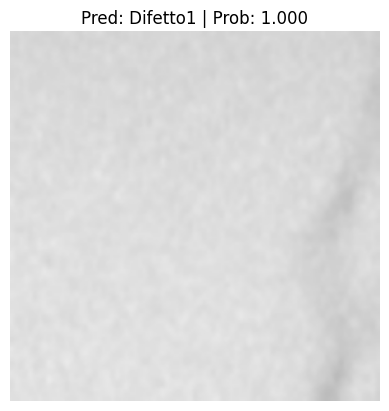

In [ ]:
# Setup custom image path
custom_image_path_1 = "/content/extracted_data/DB - Copy/testing/Difetto1/RRT-101R_Img1_A80_S4_[16][1].png"
img=cv2.imread(custom_image_path_1)
img=cv2.resize(img,(224,224))
cv2.imwrite('/content/sample_data/new_image.png',img)
custom_image_path_2 = '/content/sample_data/new_image.png'
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path_2,
                    class_names=class_names)

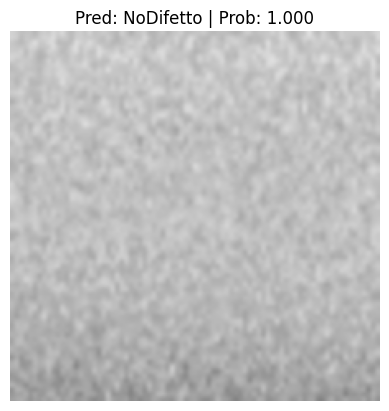

In [ ]:
# Setup custom image path
custom_image_path_1 = "/content/extracted_data/DB - Copy/testing/NoDifetto/RRT-101R_Img4_A80_S6_[32][4].png"
img=cv2.imread(custom_image_path_1)
img=cv2.resize(img,(224,224))
cv2.imwrite('/content/sample_data/new_image.png_1',img)
custom_image_path_2 = '/content/sample_data/new_image.png_1'
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path_2,
                    class_names=class_names)

**Evaluation**


---



In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_set = ImageFolder(test_dir, transform=transform)

In [ ]:
batch_size = 32  # Adjust this based on your available memory
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
true_labels = []
predicted_labels = []
predicted_scores = []

In [ ]:
pretrained_vit.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the same device as the model

        outputs = pretrained_vit(images)
        _, predicted = torch.max(outputs, 1)
        predicted_prob = torch.softmax(outputs, dim=1)

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
        predicted_scores.extend(predicted_prob.tolist())

In [ ]:
confusion = confusion_matrix(true_labels, predicted_labels)

In [ ]:
auc_score = roc_auc_score(np.eye(len(test_set.classes))[true_labels], predicted_scores, average='micro')

In [ ]:
f1 = f1_score(true_labels, predicted_labels, average='micro')

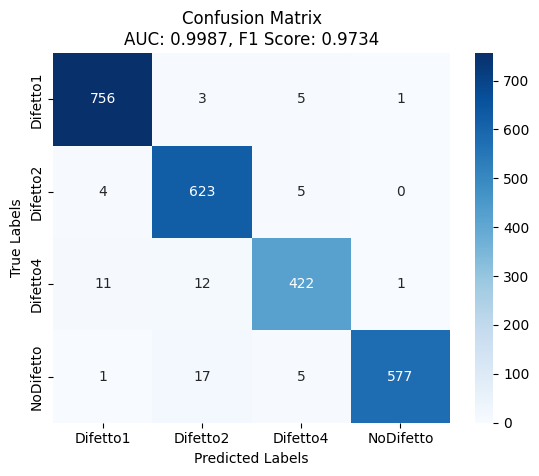

In [ ]:
class_names = test_set.classes
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix\nAUC: {:.4f}, F1 Score: {:.4f}'.format(auc_score, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Run Inference on Batches**


---



In [ ]:
model = pretrained_vit

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Stage/Stage_Falcon/test_3_ViT_Classification/model_checkpoint.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

In [ ]:
from glob import glob
import cv2
import os

In [ ]:
patches_dir = '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches'

In [ ]:
all_images=[]
for root, dirs, files in sorted(os.walk(patches_dir)):
  for subdirectory in sorted(dirs):
    dir = os.path.join(patches_dir ,subdirectory)
    patches = sorted(glob(os.path.join(dir,'*.png')))
    all_images.append({'image':subdirectory,
                       'patches':patches})

In [ ]:
print(all_images)
print(len(all_images))
print(len(all_images[0]['patches']))

[{'image': 'image1', 'patches': ['/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_1.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_10.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_11.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_12.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_13.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_14.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_15.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_16.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_17.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_18.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/patches/image1/patch_19.png', '/content/drive/MyDrive/Stage/Stage_Falcon/inference/pa

In [ ]:
for item in all_images:
  print(item['patches'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20/patch_21.png_is_NoDifetto_avec_une_prob_tensor(0.9999)_.png
True
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20/patch_22.png_is_NoDifetto_avec_une_prob_tensor(1.0000)_.png
True
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20/patch_23.png_is_NoDifetto_avec_une_prob_tensor(1.0000)_.png
True
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20/patch_24.png_is_NoDifetto_avec_une_prob_tensor(1.0000)_.png
True
/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches/image20
/content/drive/MyDrive/Stage/Stage_Fal

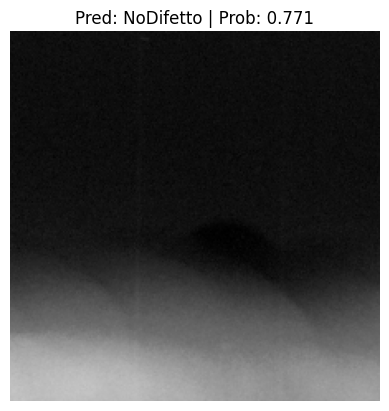

In [ ]:
for item in all_images:
  for img_path in item['patches']:
    pred,prob = pred_and_plot_image(model=model,
                    image_path=img_path,
                    class_names=class_names)
    filename = os.path.basename(img_path) +'_is_'+ str(pred) + '_avec_une_prob_'+ str(prob) + '_.png'
    save_dir = os.path.join('/content/drive/MyDrive/Stage/Stage_Falcon/inference/inference_patches',str(item['image']))
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    filee = os.path.join(save_dir,filename)
    print(filee)
    img =cv2.imread(img_path)
    boo = cv2.imwrite(filee,img)
    print(boo)


In [ ]:
for item in all_images:
  for img_path in item['patches']:
    pred_and_plot_image(model=model,
                    image_path=img_path,
                    class_names=class_names)

In [ ]:
# Assuming you have an input tensor 'input_data'
input_data = ...  # Prepare your input data

# Perform any necessary preprocessing on the input data
# ...

# Add a batch dimension if needed
input_data = input_data.unsqueeze(0)  # Add batch dimension if input_data is a single sample

# Convert the input data to the appropriate datatype and move it to the device
input_data = input_data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))